# Quantum MNIST

## Introduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import z_feature_map
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
from datasets import Dataset, DatasetDict

algorithm_globals.random_seed = 12345
estimator = Estimator()

/home/lsjcp/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Differences between a QCNN and CCNN

### 1.2 Quantum Convolutional Neural Networks 

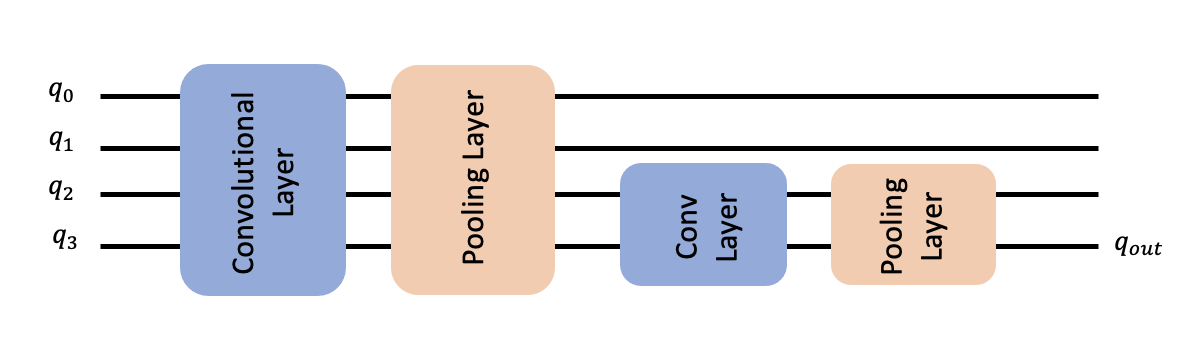


Figure 2: Example QCNN containing four qubits. The first Convolutional Layer acts on all the qubits. This is followed by the first pooling layer, which reduces the dimensionality of the QCNN from four qubits to two qubits by disregarding the first two. The second Convolutional layer then detects features between the two qubits still in use in the QCNN, followed by another pooling layer, which reduces the dimensionality from two qubits to one, which will be our output qubit.

### 2.1 Convolutional Layer

In [34]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

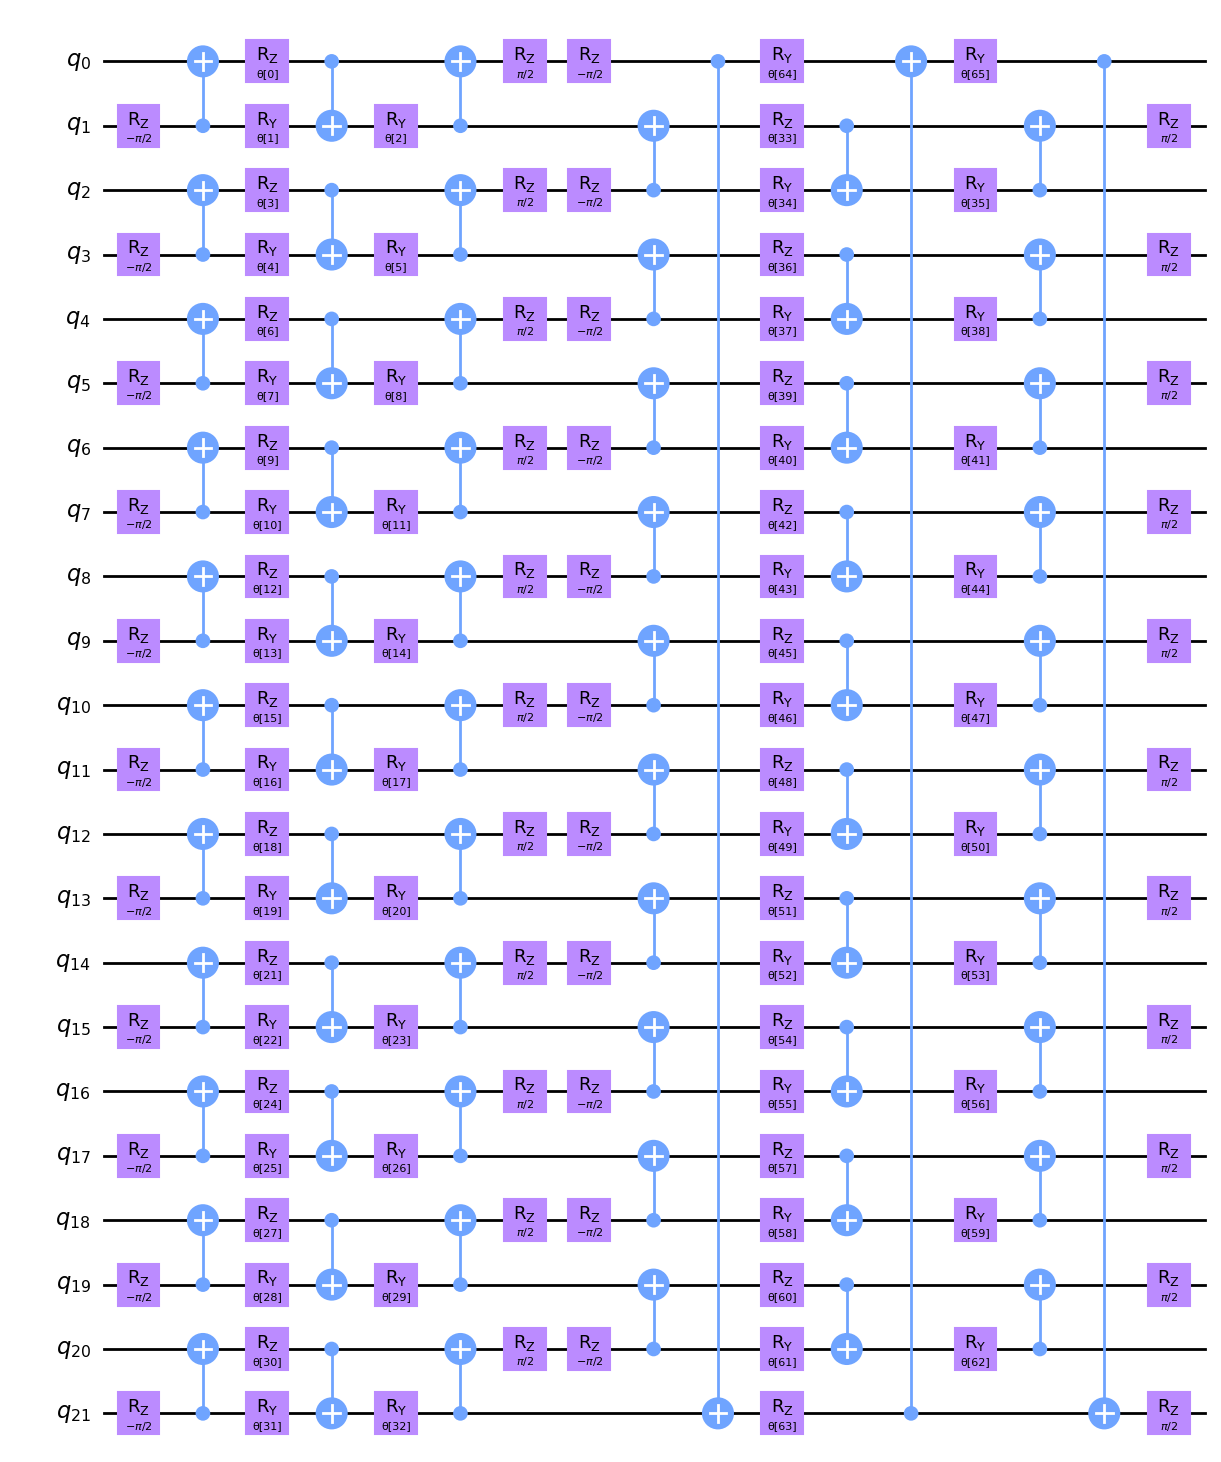

In [123]:
circuit = conv_layer(22, "θ")
circuit.decompose().draw("mpl", style="clifford")

### 2.2 Pooling Layer

As this setting will handle odd length arrays, a new pooling circuit is introduced that handles arbitrary n to 1 pooling

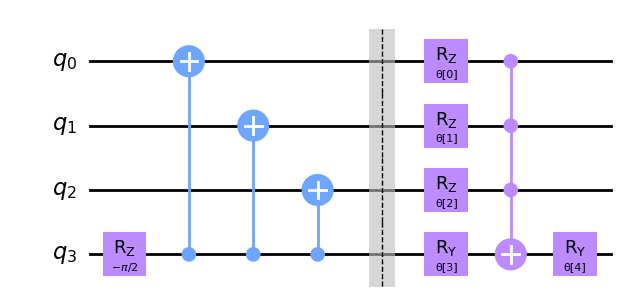

In [ ]:
def original_pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


def pool_circuit_odd_aestheic(params):
    target = QuantumCircuit(3)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.cx(1, 2)
    target.barrier()
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.rz(params[2], 2)
    target.ccx(0, 2, 1)
    target.ry(params[3], 1)

    return target

def pool_circuit_odd(params):
    target = QuantumCircuit(3)
    target.rz(-np.pi / 2, 2)
    target.cx(2, 1)
    target.cx(2, 0)
    target.barrier()
    target.rz(params[0], 0)
    target.rz(params[1], 1)
    target.ry(params[2], 2)
    target.ccx(0, 1, 2)
    target.ry(params[3], 2)

    return target

def generalized_pooling(num_qubits, params):
    """
    Generalized n->1 pooling block.
    All qubits [0..n-2] are pooled into qubit (n-1), the sink.
    """
    qc = QuantumCircuit(num_qubits)
    sink = num_qubits - 1
    sources = list(range(num_qubits - 1))

    # Basis change on sink (consistent with 2->1 pooling)
    qc.rz(-np.pi/2, sink)
    # Entangle sink with all sources
    for q in sources:
        qc.cx(sink, q)

    qc.barrier()

    # Local rotations on sources (discarded qubits)
    for i, q in enumerate(sources):
        qc.rz(params[i], q)

    # Initial rotation on sink
    qc.ry(params[len(sources)], sink)

    # Multi-controlled X (generalized Toffoli) from all sources into sink
    qc.mcx(sources, sink)

    # Final learnable rotation on sink
    qc.ry(params[len(sources)+1], sink)

    return qc


params = ParameterVector("θ", length=5)
circuit = generalized_pooling(4, params)
circuit.draw("mpl", style="clifford")

Sinks: [1, 4, 8, 12, 16, 19, 21]


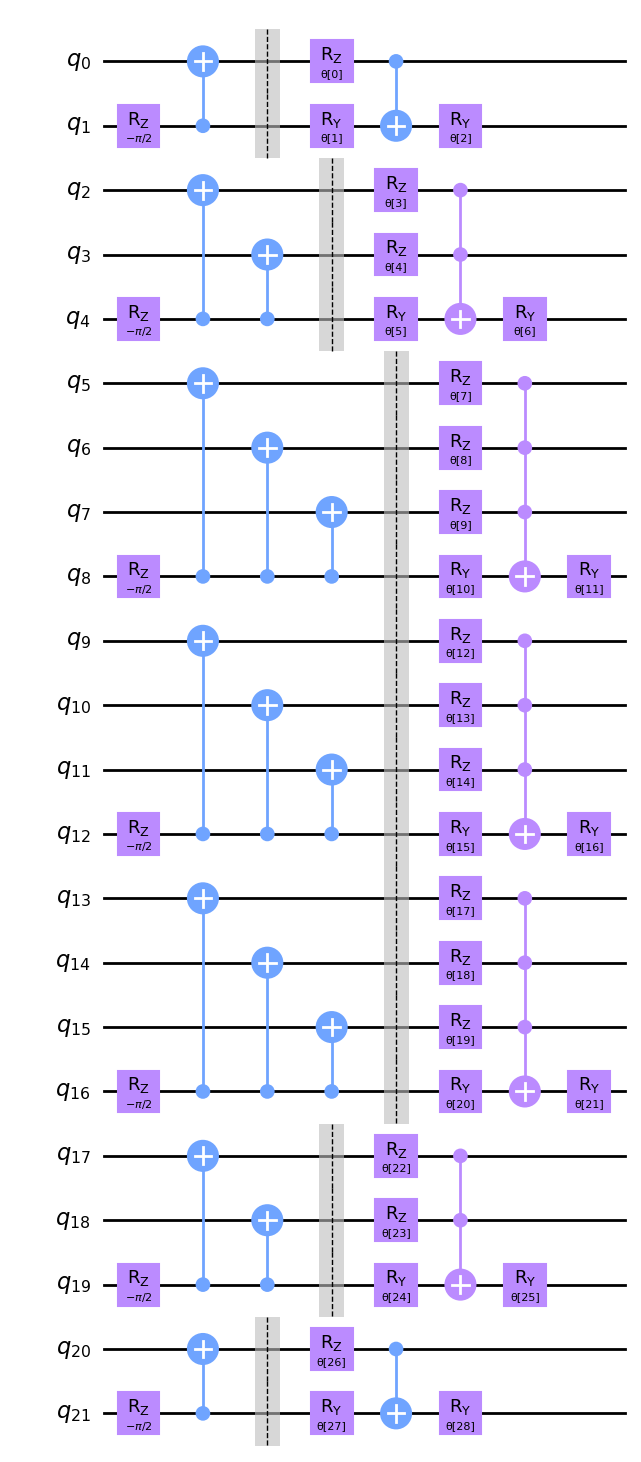

In [90]:
def pool_layer(pools, param_prefix):
    """ poools is a 2d array where each row will be pooled into the list qbit of the group """
    num_qubits = sum(count for count in pools)
    param_count = sum(count + 1 for count in pools)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    circuit_index = 0
    sinks = []
    params = ParameterVector(param_prefix, param_count)
    for length in pools:
        sub_param_count = length + 1
        qbit_range = range(circuit_index, circuit_index + length)
        sub_params = params[param_index : (param_index + sub_param_count)]
        sub_circuit = generalized_pooling(length, sub_params)
        qc = qc.compose(sub_circuit, qbit_range)
        #qc.barrier()
        sinks.append(circuit_index + length - 1)
        param_index += sub_param_count
        circuit_index += length
    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return [qc, sinks]


[circuit, sinks] = pool_layer([2,3,4,4,4,3,2], "θ")
print("Sinks:", sinks)
circuit.decompose().draw("mpl", style="clifford")



## 3. Load MNIST Dataset

In [7]:
import pandas as pd
from datasets import Dataset, DatasetDict
from huggingface_hub import hf_hub_download, list_repo_files

def load_dataset_via_pandas(repo_id: str, revision: str = "main") -> DatasetDict:
    """
    Load a DatasetDict from a remote JSONL-based dataset repo on Hugging Face Hub
    using pandas as a backend to avoid ArrowIndexError.
    """
    files = list_repo_files(repo_id, repo_type="dataset", revision=revision)
    jsonl_files = [f for f in files if f.endswith(".jsonl")]

    dataset_dict = {}
    for f in jsonl_files:
        split = f.split("/")[-1].replace(".jsonl", "")
        
        local_path = hf_hub_download(repo_id, f, repo_type="dataset", revision=revision)
        
        df = pd.read_json(local_path, lines=True)
        dataset_dict[split] = Dataset.from_pandas(df, preserve_index=False)

    return DatasetDict(dataset_dict)


In [8]:
ds = load_dataset_via_pandas("ljcamargo/quantum_mnist")

Print an example from dataset

In [10]:
print(ds["train"][0])

{'id': 'image_0000', 'label': 5, 'data': [[[None, None], [None, None], [-0.149601325392723, 0.005215304903686001], [-0.08917247503995801, -0.14660874009132302]], [[None, None], [-0.233030676841735, 0.1456268876791], [0.5733898878097531, -0.131742104887962], [-0.47518700361251803, -0.008986375294625001]], [[-0.095472157001495, 0.021066591143608003], [-0.093247435986995, -0.053984947502613005], [0.281668633222579, 0.060419723391532], [-0.17303779721260001, 0.020672706887125]], [[0.008183792233467001, -0.030594922602176004], [0.14900013804435702, 0.005881448742002001], [-0.6563084721565241, 0.045217830687761], [1.0, 0.0]], [[0.12745776772499, 0.050290331244468], [-0.23090863227844202, -0.11138548702001501], [0.126638650894165, 0.128920167684555], [-0.17303779721260001, -0.02067270129919]], [[None, None], [0.20799903571605602, 0.10138563811779001], [-0.0035532638430590003, -0.080148451030254], [-0.47518700361251803, 0.008986374363303]], [[None, None], [None, None], [0.075786158442497, -0.1

Now, lets plot an image to see how the data looks and how the image would look if reverted the compactation

In [11]:
def replace_nan_pixels(arr: np.ndarray, fill_value: complex = 0+0j) -> np.ndarray:
    """
    Replace NaN+NaN pixels in a complex array with a specified fill value.
    
    Args:
        arr : np.ndarray
            Complex array with NaNs for excluded pixels.
        fill_value : complex
            Value to replace NaN pixels with.
    
    Returns:
        np.ndarray : new array with NaNs replaced.
    """
    out = arr.copy()
    mask = np.isnan(arr.real) & np.isnan(arr.imag)
    out[mask] = fill_value
    return out

In [103]:
def get_topology_from_array(array):
    return [len([item for item in row if item != [None, None]]) for row in array]

In [112]:
row = ds["train"][0]   # or ds["train"].shuffle()[42]
row_data = row["data"]

# Transposing the row data to match the expected format
row_data = [[row[i] for row in row_data] for i in range(len(row_data[0]))]

raw_complex_array = np.array([
    [
        complex(r if r is not None else np.nan, i if i is not None else np.nan)
        for r, i in row
    ]
    for row in row_data
])
raw_complex_array = raw_complex_array.T
topology = get_topology_from_array(row_data)
complex_array = replace_nan_pixels(np.array(raw_complex_array))
print("Topology", topology)
print("Real")
print(np.real(complex_array))
print("Imaginary")
print(np.imag(complex_array))

Topology [3, 5, 7, 7]
Real
[[ 0.          0.         -0.14960133 -0.08917248]
 [ 0.         -0.23303068  0.57338989 -0.475187  ]
 [-0.09547216 -0.09324744  0.28166863 -0.1730378 ]
 [ 0.00818379  0.14900014 -0.65630847  1.        ]
 [ 0.12745777 -0.23090863  0.12663865 -0.1730378 ]
 [ 0.          0.20799904 -0.00355326 -0.475187  ]
 [ 0.          0.          0.07578616 -0.08917249]]
Imaginary
[[ 0.          0.          0.0052153  -0.14660874]
 [ 0.          0.14562689 -0.1317421  -0.00898638]
 [ 0.02106659 -0.05398495  0.06041972  0.02067271]
 [-0.03059492  0.00588145  0.04521783  0.        ]
 [ 0.05029033 -0.11138549  0.12892017 -0.0206727 ]
 [ 0.          0.10138564 -0.08014845  0.00898637]
 [ 0.          0.         -0.10029694  0.14660874]]


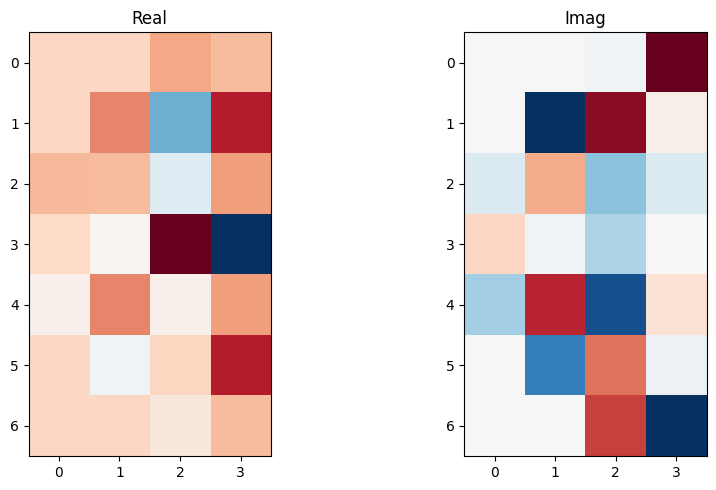

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.real(complex_array), cmap='RdBu')
axes[0].set_title('Real')
axes[1].imshow(np.imag(complex_array), cmap='RdBu')
axes[1].set_title('Imag')

plt.tight_layout()
plt.show()

Now let's restore the Hermitian Symmetry and untruncate to show how the image would look if original size was restored. This will depict how the compression proposed would impact on the perception of the image

In [14]:
import math

def restore_hermitian(truncated, original_shape):
    h, w = original_shape
    restored = np.zeros((h, w), dtype=truncated.dtype)
    restored[:, :truncated.shape[1]] = truncated
    
    truncated_w = truncated.shape[1]
    offset = 0 if w % 2 == 0 else -1 
    start_j = truncated_w + offset
    for j in range(1, start_j+1):
        restored[:, w - j] = np.conj(restored[::-1, j-1])
    
    return restored

def untruncate_fft(truncated, original_shape):
    """Untruncate FFT data back to original shape"""
    h, w = original_shape
    padded = np.zeros(original_shape, dtype=np.complex64)
    
    th, tw = truncated.shape
    top = math.ceil((h - th) / 2)
    left = math.ceil((w - tw) / 2)
    
    padded[top:top + th, left:left + tw] = truncated
    return padded

In [114]:
truncated_shape = np.floor(np.array(row['original_shape']) * row['truncate_factor']).astype(int)
restored_hermitian = restore_hermitian(complex_array, truncated_shape)
restored_untruncated = untruncate_fft(restored_hermitian, row['original_shape'])
restored_unfft = np.fft.ifftn(np.fft.ifftshift(restored_untruncated), norm='forward')

print("Original MNIST Shape", row['original_shape'])
print("Truncated Shape", truncated_shape)

Original MNIST Shape [28, 28]
Truncated Shape [7 7]


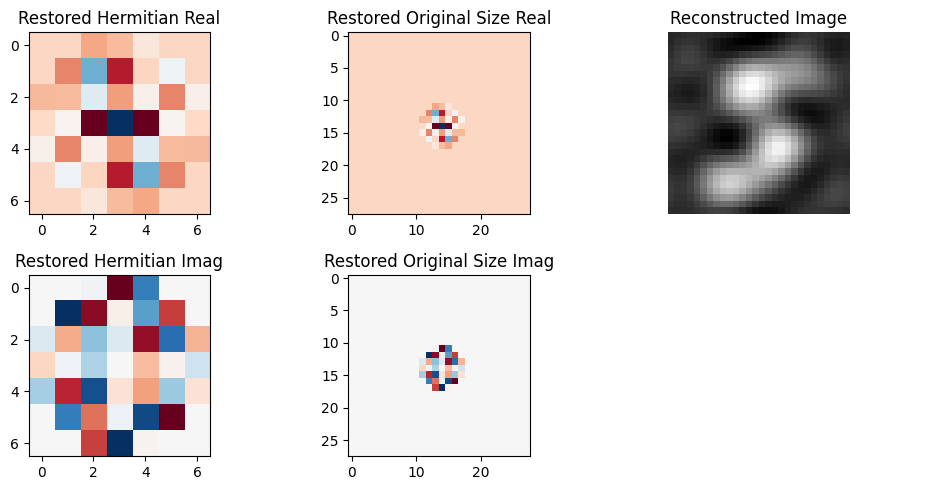

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes[0,0].imshow(np.real(restored_hermitian), cmap='RdBu')
axes[0,0].set_title('Restored Hermitian Real')
axes[1,0].imshow(np.imag(restored_hermitian), cmap='RdBu')
axes[1,0].set_title('Restored Hermitian Imag')

axes[0,1].imshow(np.real(restored_untruncated), cmap='RdBu')
axes[0,1].set_title('Restored Original Size Real')
axes[1,1].imshow(np.imag(restored_untruncated), cmap='RdBu')
axes[1,1].set_title('Restored Original Size Imag')

axes[0, 2].imshow(np.real(restored_unfft), cmap='gray')
axes[0, 2].set_title('Reconstructed Image')
axes[0, 2].axis('off')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Embed Complex Array from Image into Quantum Circuit

Let's get the rows and columns and then linearize our complex array, in this example altough the array has 4x7 shape = 28qbits, the pixels that lay outside the circle are also excluded, that why in the dataset they are stored as null values, so we only be embedding the shape tensor minus the excluded (4*7) - 6 = 22qubits and we will flatten this sequentially skipping null values.

In [17]:
print("Original Array with nan+naj corresponding to excluded qbits\n", raw_complex_array)

Original Array with nan+naj corresponding to excluded qbits
 [[        nan       +nanj         nan       +nanj -0.14960133+0.0052153j
  -0.08917248-0.14660874j]
 [        nan       +nanj -0.23303068+0.14562689j  0.57338989-0.1317421j
  -0.475187  -0.00898638j]
 [-0.09547216+0.02106659j -0.09324744-0.05398495j  0.28166863+0.06041972j
  -0.1730378 +0.02067271j]
 [ 0.00818379-0.03059492j  0.14900014+0.00588145j -0.65630847+0.04521783j
   1.        +0.j        ]
 [ 0.12745777+0.05029033j -0.23090863-0.11138549j  0.12663865+0.12892017j
  -0.1730378 -0.0206727j ]
 [        nan       +nanj  0.20799904+0.10138564j -0.00355326-0.08014845j
  -0.475187  +0.00898637j]
 [        nan       +nanj         nan       +nanj  0.07578616-0.10029694j
  -0.08917249+0.14660874j]]


Let's flatten into 1d array of complex items but removing the empty values

In [115]:
raw_complex_array = raw_complex_array.T # <- Transpose
print("Shape of the array", raw_complex_array.shape)

[w, h] = raw_complex_array.shape

# flatten
flat = raw_complex_array.flatten()
print("Flatened 1d array size", flat.shape)
# filter out "null" complex numbers (both real and imag are nan)
flat_filtered = flat[~(np.isnan(flat.real) & np.isnan(flat.imag))]
print("Flatened 1d array size minus Nan", flat_filtered.shape)
print("\nOriginal\n", raw_complex_array)
print("\nFlattened Array minus Nan\n", flat_filtered)

Shape of the array (4, 7)
Flatened 1d array size (28,)
Flatened 1d array size minus Nan (22,)

Original
 [[        nan       +nanj         nan       +nanj -0.09547216+0.02106659j
   0.00818379-0.03059492j  0.12745777+0.05029033j         nan       +nanj
          nan       +nanj]
 [        nan       +nanj -0.23303068+0.14562689j -0.09324744-0.05398495j
   0.14900014+0.00588145j -0.23090863-0.11138549j  0.20799904+0.10138564j
          nan       +nanj]
 [-0.14960133+0.0052153j   0.57338989-0.1317421j   0.28166863+0.06041972j
  -0.65630847+0.04521783j  0.12663865+0.12892017j -0.00355326-0.08014845j
   0.07578616-0.10029694j]
 [-0.08917248-0.14660874j -0.475187  -0.00898638j -0.1730378 +0.02067271j
   1.        +0.j         -0.1730378 -0.0206727j  -0.475187  +0.00898637j
  -0.08917249+0.14660874j]]

Flattened Array minus Nan
 [-0.09547216+0.02106659j  0.00818379-0.03059492j  0.12745777+0.05029033j
 -0.23303068+0.14562689j -0.09324744-0.05398495j  0.14900014+0.00588145j
 -0.23090863-0.11138

Now we can get the final amount of qbits that will be used

In [116]:
circuit_size = len(flat_filtered)
print("Qbit length", circuit_size)

Qbit length 22


#### Direct Parameter Binding

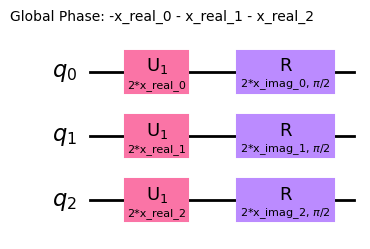

In [23]:
from qiskit.circuit import QuantumCircuit, Parameter

def create_complex_feature_map(n_features):
    qc = QuantumCircuit(n_features)
    
    # Create parameters for real and imaginary parts
    real_params = [Parameter(f'x_real_{i}') for i in range(n_features)]
    imag_params = [Parameter(f'x_imag_{i}') for i in range(n_features)]
    
    for i in range(n_features):
        # Real part controls RZ, imaginary part controls RY
        qc.rz(2 * real_params[i], i)
        qc.ry(2 * imag_params[i], i)
    
    return qc

feature_map = create_complex_feature_map(n_features=3)
feature_map.decompose().draw("mpl", style="clifford")

#### Complex ZZ Feature Map with Pairwise Entanglement

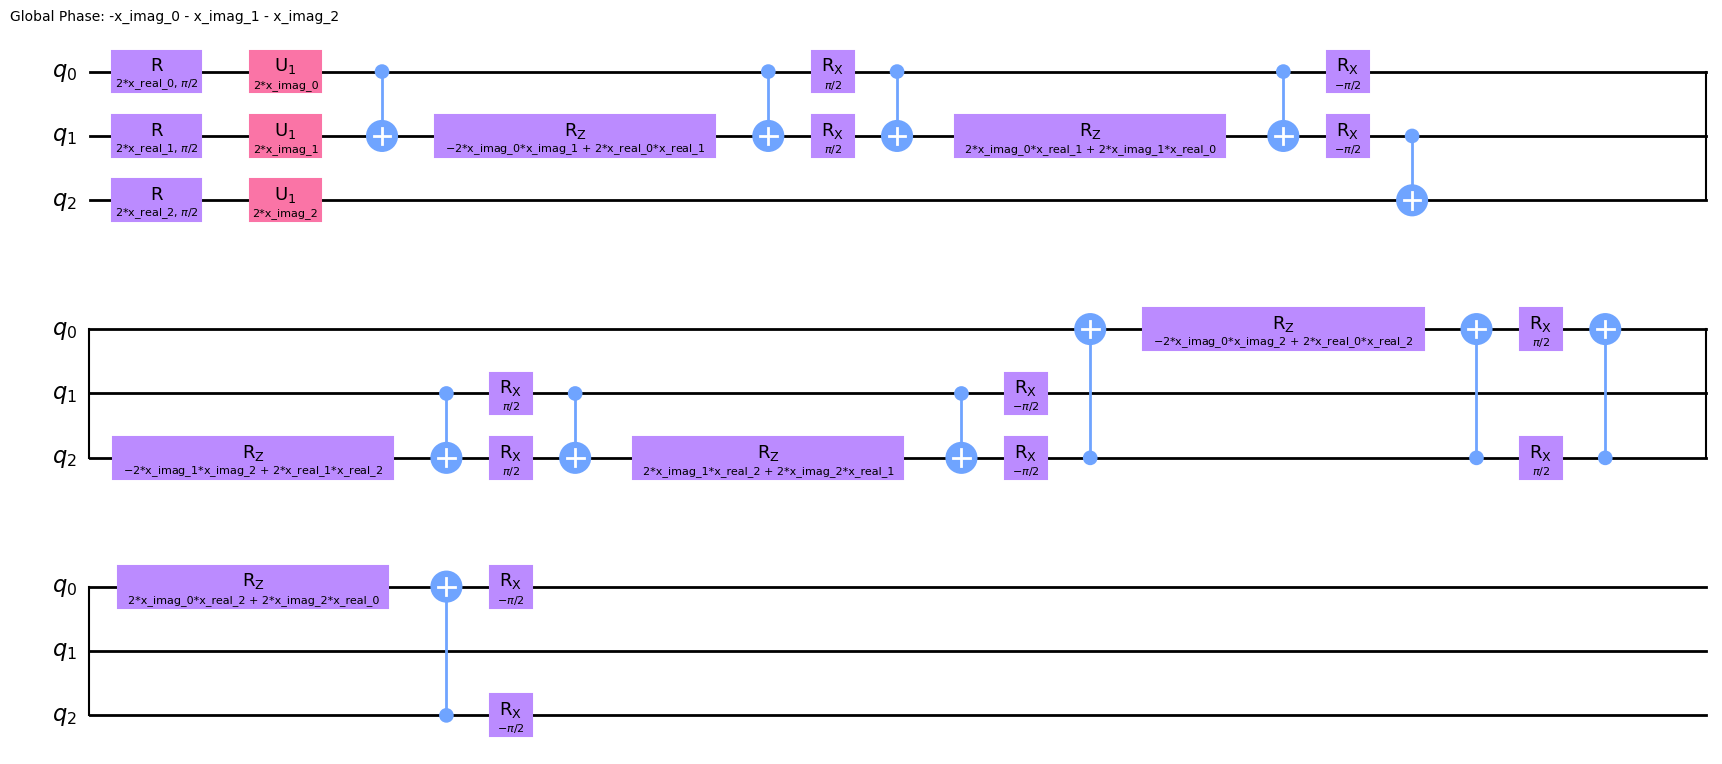

In [29]:
from qiskit.circuit import QuantumCircuit, Parameter
import numpy as np

def create_complex_zz_feature_map(n_features, entanglement='linear'):
    qc = QuantumCircuit(n_features)
    
    # Parameters for complex data
    real_params = [Parameter(f'x_real_{i}') for i in range(n_features)]
    imag_params = [Parameter(f'x_imag_{i}') for i in range(n_features)]
    
    # Single qubit rotations (like Z feature map)
    for i in range(n_features):
        qc.ry(2 * real_params[i], i)  # Real part
        qc.rz(2 * imag_params[i], i)  # Imaginary part

    def get_entangling_pairs(n_qubits, entanglement):
        """Generate entangling pairs based on topology"""
        if entanglement == 'linear':
            return [(i, i+1) for i in range(n_qubits-1)]
        elif entanglement == 'full':
            return [(i, j) for i in range(n_qubits) for j in range(i+1, n_qubits)]
        elif entanglement == 'circular':
            pairs = [(i, i+1) for i in range(n_qubits-1)]
            pairs.append((n_qubits-1, 0))  # wrap around
            return pairs
        else:
            return entanglement  # assume it's a custom list
    
    # Add ZZ-style entangling gates using complex products
    entangling_pairs = get_entangling_pairs(n_features, entanglement)
    
    for i, j in entangling_pairs:
        # ZZ interaction using product of complex numbers
        # |z_i * z_j| for magnitude, arg(z_i * z_j) for phase
        real_product = real_params[i] * real_params[j] - imag_params[i] * imag_params[j]
        imag_product = real_params[i] * imag_params[j] + imag_params[i] * real_params[j]
        
        # Apply RZZ gate with the real part of the product
        qc.rzz(2 * real_product, i, j)
        
        # Optional: Add RYY interaction for imaginary part
        qc.ryy(2 * imag_product, i, j)
    
    return qc

feature_map = create_complex_zz_feature_map(n_features=3, entanglement="circular")
feature_map.decompose().draw("mpl", style="clifford")

Let's try first with the most simple feature map without entangling

## Training

The next step is to build our model using our training data. 

To classify our system, we perform a measurement from the output circuit. The value we obtain will thus classify whether our input data contains either a vertical line or horizontal line. 

The measurement we have chosen in this tutorial is $<Z>$, i.e. the expectation value of the Pauli Z qubit for the final qubit. Measuring this expectation value, we obtain +1 or -1, which correspond to a vertical or horizontal line respectively. 

In [124]:
circuit_size

22

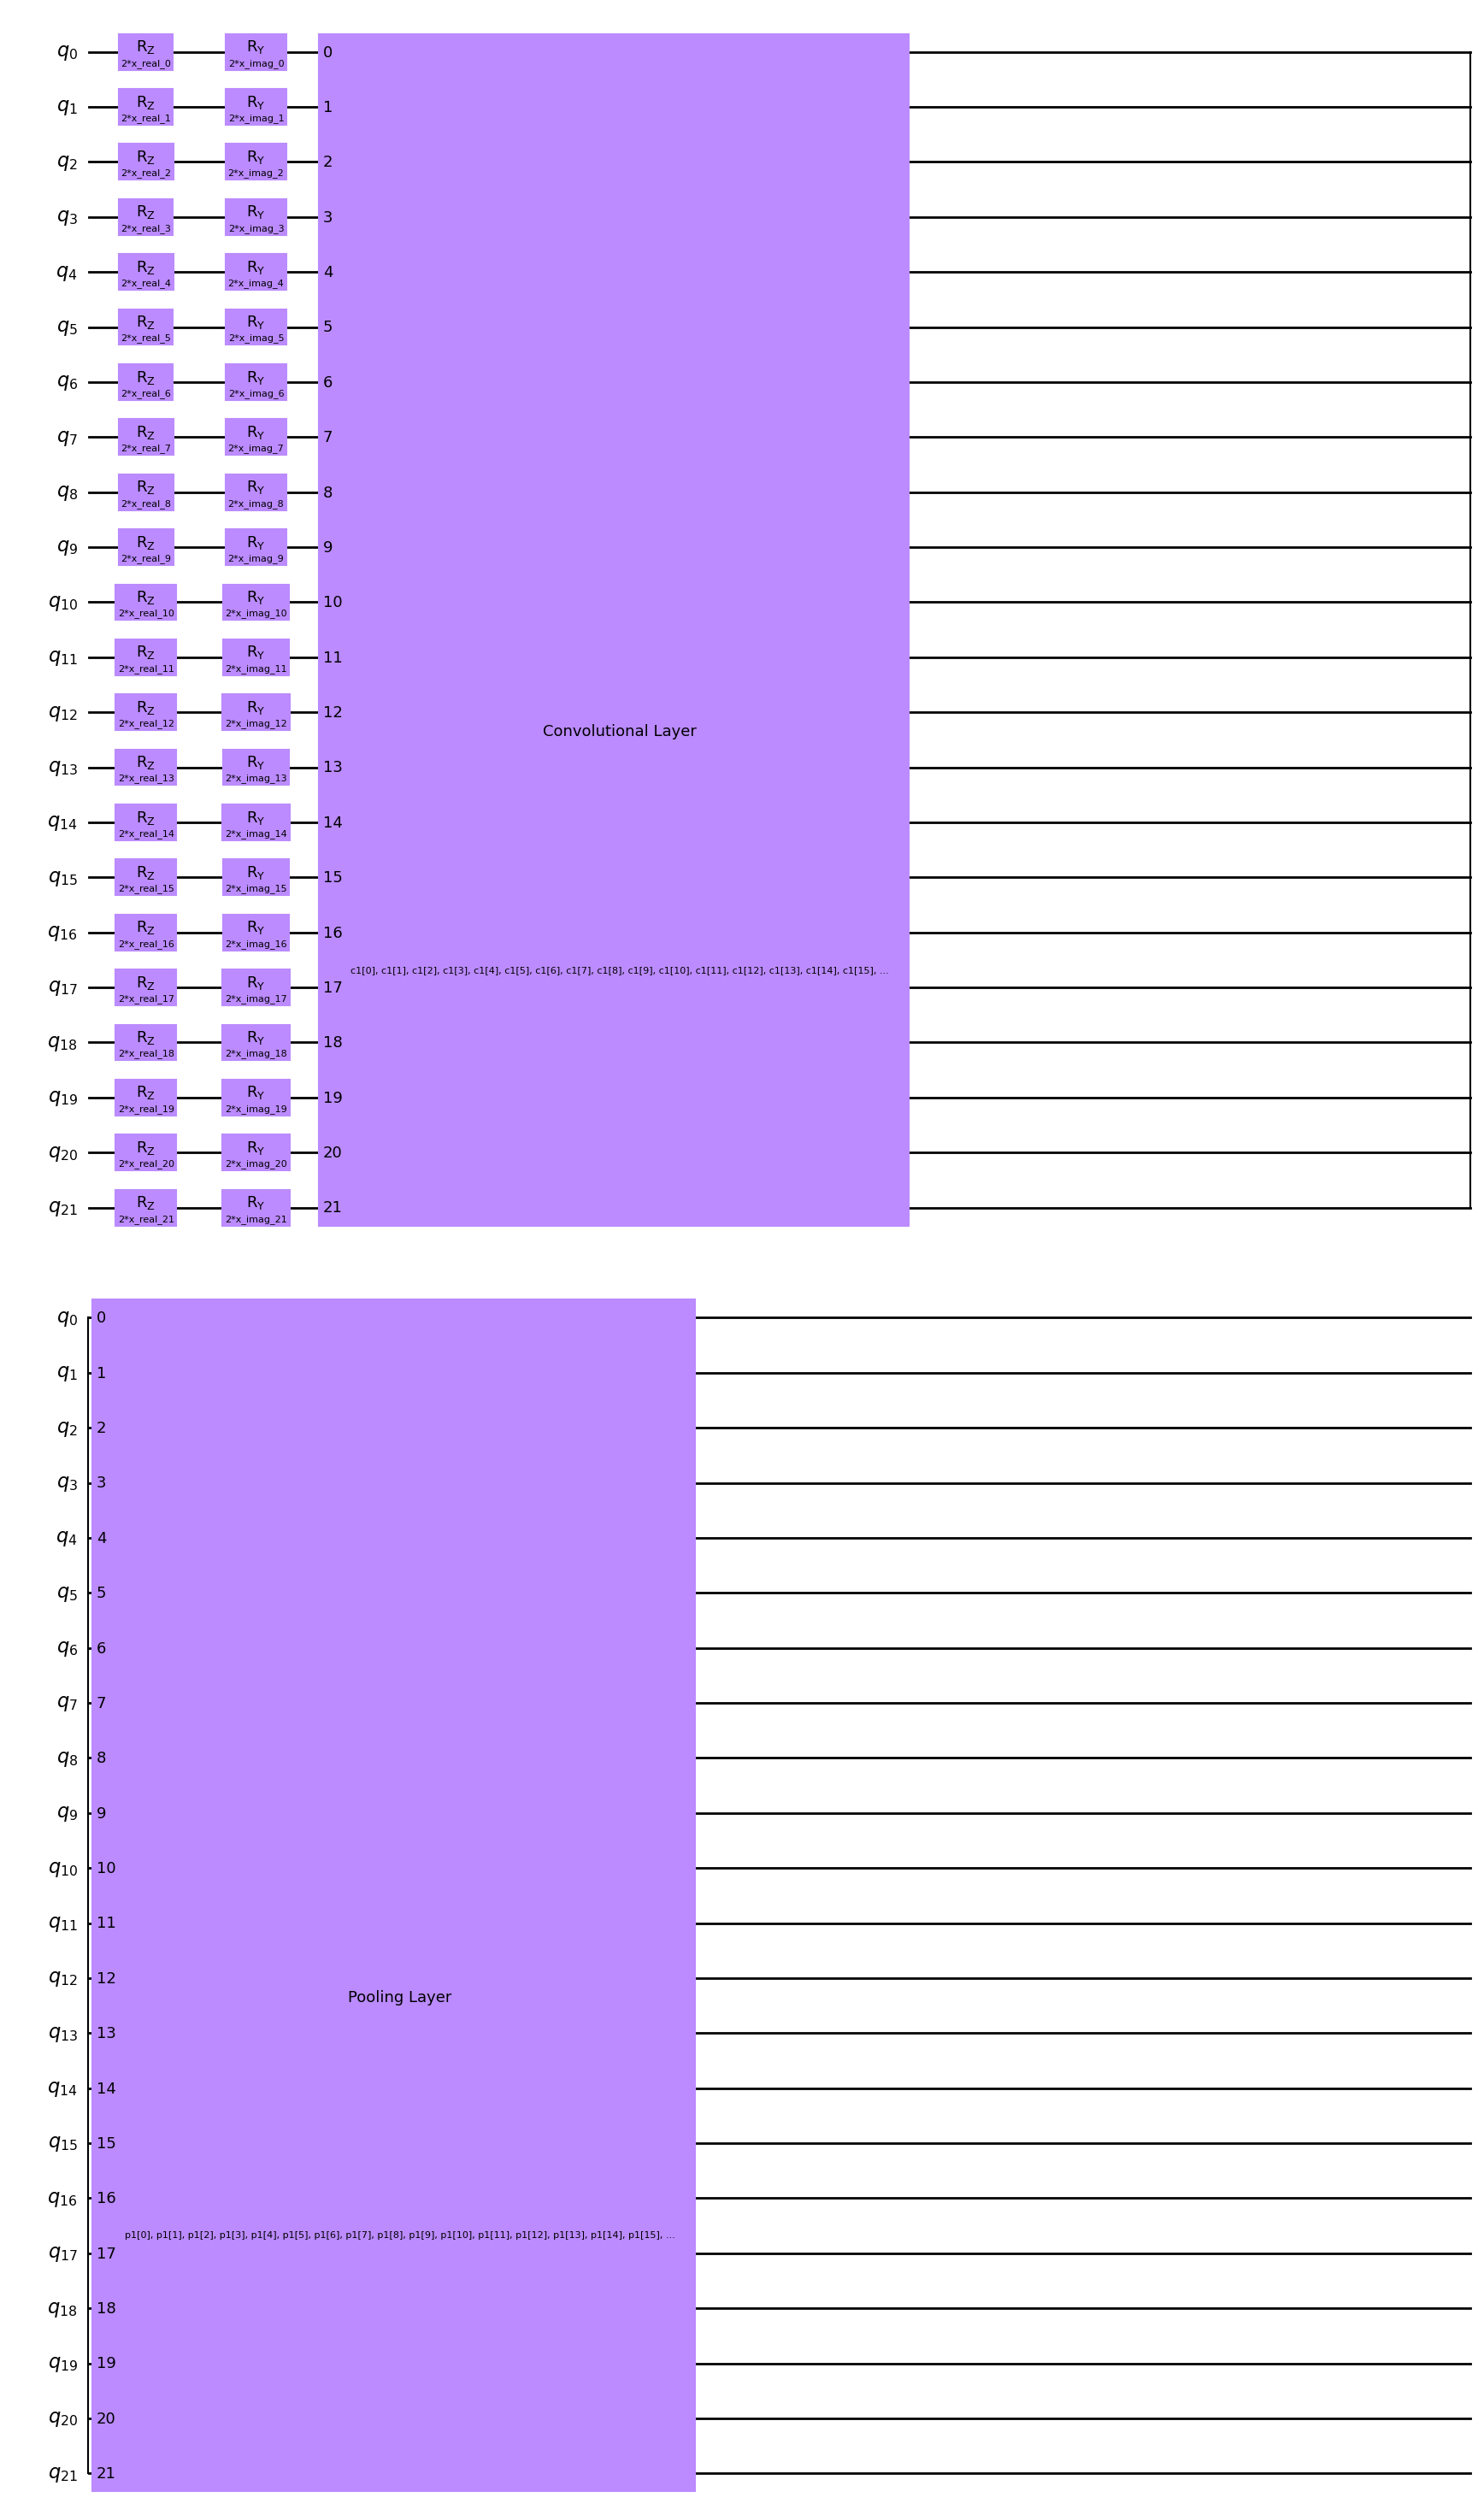

In [131]:
feature_map = create_complex_feature_map(n_features=circuit_size)
feature_map.draw("mpl", style="clifford")

ansatz = QuantumCircuit(circuit_size, name="Ansatz")

# First Convolutional Layer
convolution = conv_layer(circuit_size, "c1")
ansatz.compose(convolution, list(range(circuit_size)), inplace=True)

# First Pooling Layer
[pool, sinks] = pool_layer(topology, "p1")
ansatz.compose(pool, list(range(circuit_size)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(circuit_size, name="QNN Circuit")
circuit.compose(feature_map, range(circuit_size), inplace=True)
circuit.compose(ansatz, range(circuit_size), inplace=True)

circuit.draw("mpl", style="clifford")

In [ ]:
def qbits_to_pauli_str(qbits):
    diff = [qbits[i] - (qbits[i-1] if i > 0 else 0) for i in range(len(qbits))]
    return "".join(["I"*(q-1)+"Z" for q in diff])[::-1]


print(sinks)
pauli_string = qbits_to_pauli_str(sinks)
print(pauli_string)

[2, 7, 14, 21]
ZIIIIIIZIIIIIIZIIIIZI


In [152]:
observable = SparsePauliOp.from_list([(pauli_string, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


We will also define a callback function to use when training our model. This allows us to view and plot the loss function per each iteration in our training process.

In [153]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [154]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

After creating this classifier, we can train our QCNN using our training dataset and each image's corresponding label. Because we previously defined the callback function, we plot the overall loss of our system per iteration.

It may take some time to train the QCNN so be patient!

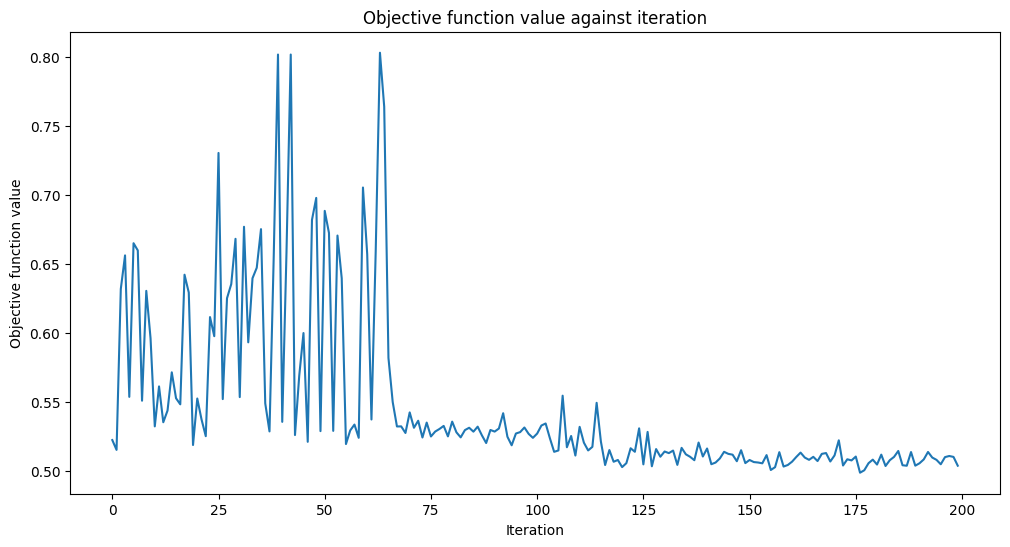

Accuracy from the train data : 94.29%


In [14]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

As we can see from above, the QCNN converges slowly, hence our `initial_point` was already close to an optimal solution. The next step is to determine whether our QCNN can classify data seen in our test image data set. 

## 6. Testing our QCNN

After building and training our dataset we now test whether our QCNN can predict images that are not from our test data set. 

Accuracy from the test data : 100.0%


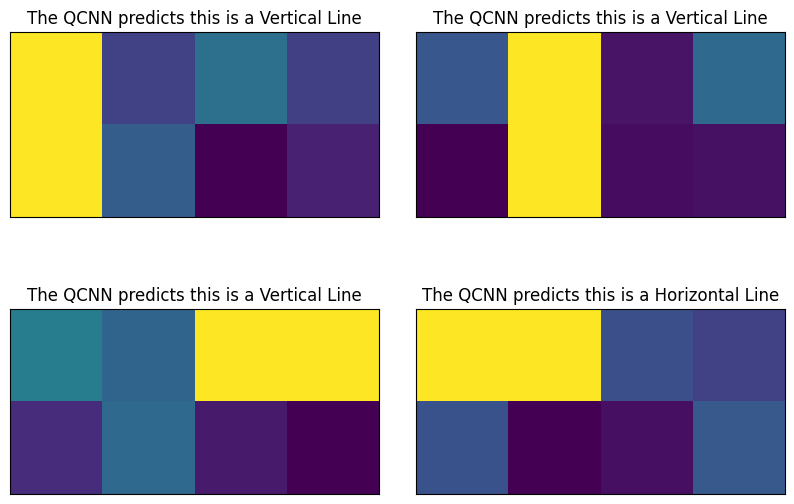

In [15]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

From above, we can indeed see that our QCNN can classify horizontal and vertical lines! Congratulations! Through the use of quantum circuits and quantum convolutional and pooling layers, you have built a Quantum Convolutional Neural Network! 